Date: 19.05.2023 \
Author: Reto Hendry

This scripts is used to find out the feature importance of the best performing models on the parameter set which is best for all models.

The best parameters are resample cube 3 and number of features 70. This can be seen in the script "etric_analysis_autoML_tools.ipynb"

In [1]:
import numpy as np
import pandas as pd
import os
import sys

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score

os.environ['PYDEVD_WARN_EVALUATION_TIMEOUT'] = '10.0'
os.environ['PYDEVD_UNBLOCK_THREADS_TIMEOUT'] = '5.0'

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from functions.function_get_feature_positions import get_feature_positions
from functions.function_export_feature_positions import export_feature_positions
from functions.function_get_label_df import get_label_df
from functions.function_get_component_array import get_component_array
from functions.function_get_best_features import get_best_features_sorted
from functions.function_resample_4d_array import resample_4d_array

## Prepare Data

In [2]:
# parameters to define
component = [1]
resample_cube = 3
number_of_features = 70

##############################################

# get the label data
df_label = get_label_df(data_path_optional="../../data/")

# get the MVPA data arrays
component_array_5d = get_component_array(component, data_path_optional="../../data/")
print(f"shape of component_array_5d: {component_array_5d.shape}")

sample_array_4d = resample_4d_array(component_array_5d[0], resample_cube)
print(f"shape of resampled sample_array_4d: {sample_array_4d.shape}")

# get the sorted feature list
best_feature_list = get_best_features_sorted(
    sample_array_4d, df_label
)

# select desired number of features
best_features = best_feature_list[:number_of_features]

/home/tahendry/Documents/master_thesis/master_thesis_repo/functions/function_get_label_df.py:42: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_label = (pd.read_excel(os.path.join(data_path, label_file),


shape of component_array_5d: (1, 90, 91, 109, 91)
Resampling in progress...


100%|██████████| 90/90 [00:00<00:00, 115.11it/s]


shape of resampled sample_array_4d: (90, 31, 37, 31)
Calculating list of best features ...


100%|██████████| 35556/35556 [00:34<00:00, 1036.86it/s]


In [3]:
df_label.head()

,Conn_SubjNr,Cond
0,1,1
1,2,1
2,3,1
3,4,0
4,5,1


In [4]:
sample_array_4d.shape

(90, 31, 37, 31)

In [5]:
# reshape 4d array to dataframe
sample_df = pd.DataFrame(
    sample_array_4d.reshape(sample_array_4d.shape[0], -1)
    ).iloc[:, best_features]    

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    sample_df, 
    df_label["Cond"], 
    test_size=0.2, 
    random_state=42,
    stratify=df_label["Cond"]
)

## Load and deploy model

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Average CV score on the training set was: 0.8472222222222222
best_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, max_features=0.2, min_samples_leaf=1, min_samples_split=14, n_estimators=100, subsample=0.3)
# Fix random state in exported estimator
if hasattr(best_model, 'random_state'):
    setattr(best_model, 'random_state', 1)

best_model.fit(x_train, y_train)
results = best_model.predict(x_test)

In [7]:
best_model

GradientBoostingClassifier(max_depth=2, max_features=0.2, min_samples_split=14,
                           random_state=1, subsample=0.3)

In [8]:
results


array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [9]:
np.array(y_test)

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [10]:
# Define the cross-validation strategy
cv_stratified = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, x_train, y_train, cv=cv_stratified)
cv_mean_accuracy = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Make predictions on the test set
y_pred = best_model.predict(x_test)

# Calculate the accuracy and F1 score on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred, average="weighted")
test_precision_score = precision_score(y_test, y_pred, average="weighted")

In [11]:
# print all the results
print(f"cv_mean_accuracy: {cv_mean_accuracy}")
print(f"cv_std: {cv_std}")
print(f"test_accuracy: {test_accuracy}")
print(f"test_f1_score: {test_f1_score}")
print(f"test_precision_score: {test_precision_score}")

cv_mean_accuracy: 0.8472222222222222
cv_std: 0.1145307118227128
test_accuracy: 0.8333333333333334
test_f1_score: 0.8328173374613004
test_precision_score: 0.8374999999999999


## get feature importance

In [12]:
# Get feature importances
importances = best_model.feature_importances_

# Since we don't have original feature names due to reshaping and selecting best features
# We'll use indices as names
feature_names = sample_df.columns

# Create a pandas dataframe to display feature importance
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = feature_names
feature_importance_df['Relative_Importance'] = importances

# Calculate the maximum of Relative Importance
max_importance = feature_importance_df['Relative_Importance'].max()

# Calculate the sum of Relative Importance
sum_importance = feature_importance_df['Relative_Importance'].sum()

# Add Scaled Importance to the dataframe
feature_importance_df['Scaled_Importance'] = feature_importance_df['Relative_Importance'] / max_importance

# Add Percentage to the dataframe
feature_importance_df['Percentage'] = feature_importance_df['Relative_Importance'] / sum_importance

feature_importance_df = (feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=True)
                        .set_index('Feature'))

# display the dataframe
print(feature_importance_df)

         Relative_Importance  Scaled_Importance  Percentage
Feature                                                    
17926               0.000000           0.000000    0.000000
13468               0.000000           0.000000    0.000000
18080               0.000000           0.000000    0.000000
14327               0.000000           0.000000    0.000000
20437               0.000000           0.000000    0.000000
...                      ...                ...         ...
18925               0.041559           0.715840    0.041559
11979               0.045564           0.784831    0.045564
13181               0.048942           0.843012    0.048942
13158               0.053092           0.914493    0.053092
15351               0.058056           1.000000    0.058056

[70 rows x 3 columns]


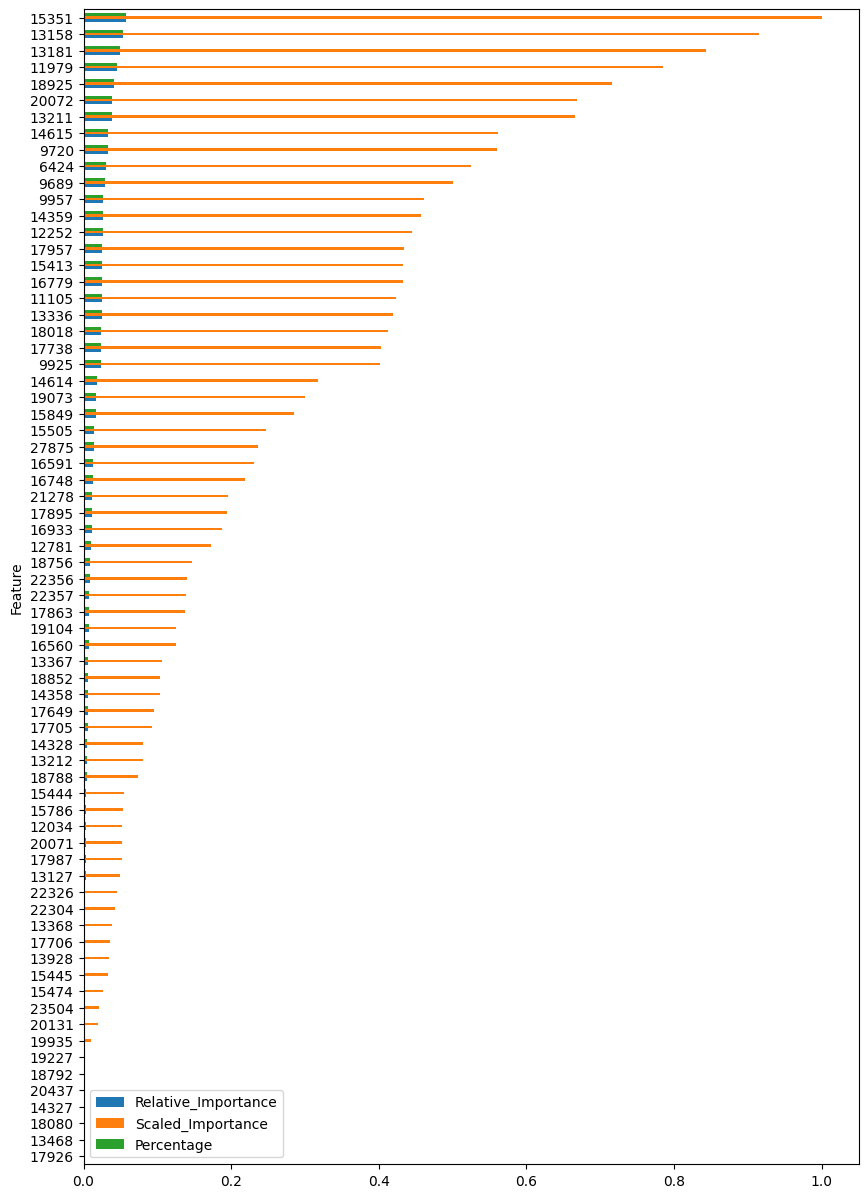

In [13]:
# Plot the importances
feature_importance_df.plot(kind='barh', figsize=(10, 15))
plt.show()

In [14]:
# export to a csv file
feature_importance_df.to_csv("feature_importance_tpot.csv")

## Export to NIfTI with feature importance

In [15]:
feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False)

,Relative_Importance,Scaled_Importance,Percentage
Feature,,,
15351,0.058056,1.000000,0.058056
13158,0.053092,0.914493,0.053092
13181,0.048942,0.843012,0.048942
11979,0.045564,0.784831,0.045564
18925,0.041559,0.715840,0.041559
...,...,...,...
14327,0.000000,0.000000,0.000000
13468,0.000000,0.000000,0.000000
18792,0.000000,0.000000,0.000000


In [16]:
index_descending = list(feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False).index)
print(type(index_descending))
print(index_descending)

importance_descending = list(feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False).loc[:, "Scaled_Importance"])
print(type(importance_descending))
print(importance_descending)

<class 'list'>
[15351, 13158, 13181, 11979, 18925, 20072, 13211, 14615, 9720, 6424, 9689, 9957, 14359, 12252, 17957, 15413, 16779, 11105, 13336, 18018, 17738, 9925, 14614, 19073, 15849, 15505, 27875, 16591, 16748, 21278, 17895, 16933, 12781, 18756, 22356, 22357, 17863, 19104, 16560, 13367, 18852, 14358, 17649, 17705, 14328, 13212, 18788, 15444, 15786, 12034, 20071, 17987, 13127, 22326, 22304, 13368, 17706, 13928, 15445, 15474, 23504, 20131, 19935, 20437, 18080, 14327, 13468, 18792, 19227, 17926]
<class 'list'>
[1.0, 0.9144934678739145, 0.8430116690092576, 0.7848314909043593, 0.7158400675226099, 0.6692086485591896, 0.6659561654179689, 0.5610731801412722, 0.5606529642503193, 0.5244450826260693, 0.49993232697779955, 0.4618109689598791, 0.45710514397862856, 0.44542171608931064, 0.4340272731547367, 0.43291221460759066, 0.4321704401132149, 0.42369570729540895, 0.4195874419222719, 0.412807304038655, 0.4030587532541393, 0.40171854091231146, 0.3172582718346205, 0.3004179480148944, 0.28501849662

In [17]:
component = 1
resample_cube = 3
number_of_features = 70
padding = [(1, 1), (1, 1), (1, 1)]
shape_resampled_array = (90, 31, 37, 31)
best_features = index_descending

# create the marker array
marker, marker_array_shape = get_feature_positions(
    top_features=best_features,
    padding=padding,
    resample_cube=resample_cube,
    shape_resampled_array=shape_resampled_array[-3:],
)

# export the feature positions to a NIfTI file
component = component
reshape_cube = resample_cube
number_of_features = number_of_features
output_path = "../NIfTY_feature_masks"
export_feature_positions(
    array_shape=marker_array_shape, 
    marker=marker, 
    output_path=output_path,
    output_filename=f"feature_importance_tpot_{reshape_cube}_{number_of_features}",
    feature_importance=importance_descending
)


done with get_feature_positions
saved feature_importance_tpot_3_70.nii successfully
